In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
from __future__ import division
from glob import glob
import os
import time
import cPickle as pickle

import scipy.linalg
import scipy.stats

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rc("figure", dpi=144)

import astropy.io.fits
import astropy.table
import astropy.units as u
import astropy.constants as c
import astropy.time

import emcee
import numdifftools

import kepler
import threebody

In [3]:
!ls -ltr *.tim

-rw-r--r-- 1 aarchiba aipsuser     3194 May 31  2013 0337-short-2.tim
-rw-r--r-- 1 aarchiba aipsuser  1709289 May 31  2013 0337+17.tim
-rw-r--r-- 1 aarchiba aipsuser    10646 May 31  2013 0337-short.tim
-rw-r--r-- 1 aarchiba aipsuser  1870476 Jun 17  2013 0337+17-scott-2013-06-06.tim
-rw-r--r-- 1 aarchiba aipsuser  6961347 Jul 31  2013 synthetic.tim
-rw-r--r-- 1 aarchiba aipsuser  1977505 Aug 15  2013 0337+17-scott-2013-08-15.tim
-rw-r--r-- 1 aarchiba aipsuser  2043963 Aug 30  2013 0337+17-scott-2013-08-29.tim
-rw-r--r-- 1 aarchiba aipsuser  1590000 Sep 19  2013 fake-pulsar.tim
-rw-r--r-- 1 aarchiba aipsuser  2078907 Jan 22  2014 0337+17-scott-2014-01-22.tim
-rw-r--r-- 1 aarchiba aipsuser  2201549 Jan 28  2014 0337+17-anne-2014-01-28.tim
-rw-r--r-- 1 aarchiba aipsuser      154 Feb  4  2014 0337+17-anne-2014-02-04.tim
-rw-r--r-- 1 aarchiba aipsuser  2186806 Feb  4  2014 0337+17-anne-2014-02-04b.tim
-rw-r--r-- 1 aarchiba aipsuser  2143978 Feb 10  2014 fake-t2.tim
-rw-r--r-- 1 aarchiba ai

## Assign pulse numbers using a three-body solution

In [4]:
fpickle = "forecaster_params.pickle"
d = pickle.load(open(fpickle,"rb"))
F = threebody.Fitter(**d)
d

{'efac': (('AO1440', 1.45), ('GBT1500', 1.11), ('WSRT1400', 1.45)),
 'files': '0337+17-anne-2014-09-22',
 'fit_pm': False,
 'fit_pos': True,
 'fit_px': False,
 'kopeikin': False,
 'parfile': '0337_tempo2_px_optical.par',
 'ppn_mode': 'heavysimple',
 'priors': ('dbeta', 'dgamma'),
 't2_astrometry': True,
 'tzrmjd_middle': False}

In [5]:
# FIXME: jumps
o = threebody.compute_orbit(F.best_parameters, F.mjds)

In [6]:
t_psr_s = o['t_psr']*86400
p = F.best_parameters
tzrmjd_base = p['tzrmjd_base']
tzrmjd_s = (p['tzrmjd']+(tzrmjd_base-F.base_mjd))*86400
phase = p['f0']*t_psr_s+p['f1']*t_psr_s**2/2.
phase -= p['f0']*tzrmjd_s+p['f1']*tzrmjd_s**2/2.

0 questionable entries


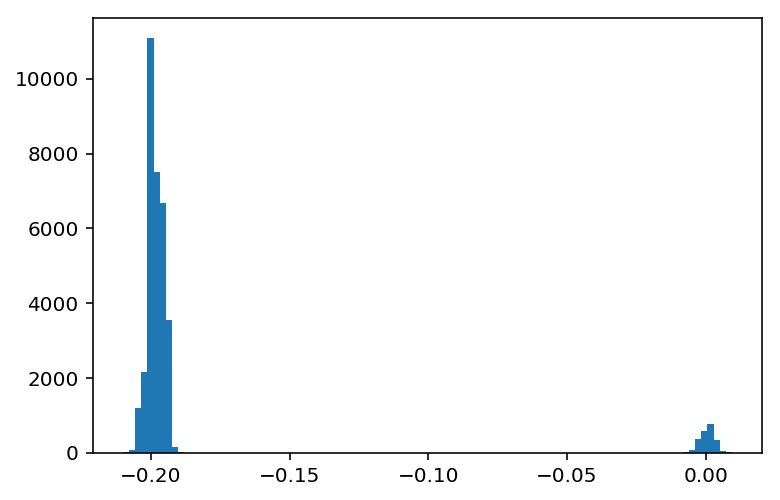

In [7]:
plt.hist(phase-np.round(phase),bins=100)
print np.sum(np.abs(phase-np.round(phase)>0.3)), "questionable entries"

## Loading in pipeline tim files

In [95]:
fpickle = "forecaster_params.pickle"
d = pickle.load(open(fpickle,"rb"))
d["files"] = "tuned_mueller"
d["toa_mode"] = "pipeline"
F = threebody.Fitter(**d)
d

{'efac': (('AO1440', 1.45), ('GBT1500', 1.11), ('WSRT1400', 1.45)),
 'files': 'tuned_mueller',
 'fit_pm': False,
 'fit_pos': True,
 'fit_px': False,
 'kopeikin': False,
 'parfile': '0337_tempo2_px_optical.par',
 'ppn_mode': 'heavysimple',
 'priors': ('dbeta', 'dgamma'),
 't2_astrometry': True,
 'toa_mode': 'pipeline',
 'tzrmjd_middle': False}

In [96]:
toa_info = threebody.read_t2_toas(F.files+".tim")
len(toa_info)

29744

In [97]:
d = pickle.load(open(fpickle,"rb"))
F_forecast = threebody.Fitter(**d)
F_forecast.best_parameters

{'acosi_i': 1.4917920737881377967,
 'acosi_o': 91.515517821405981132,
 'asini_i': 1.2175268187146886046,
 'asini_o': 74.672709901274213484,
 'd_DECJ': 3.8297379260835209625e-07,
 'd_RAJ': -9.1473641598984196357e-08,
 'dbeta': 3.137215781113322372e-05,
 'delta': -2.4326288381809617149e-10,
 'delta_lan': -5.4096316391090949558e-05,
 'dgamma': -2.5854449182822343408e-07,
 'eps1_i': 0.00068724728071223587401,
 'eps1_o': 0.035186247652040840626,
 'eps2_i': -9.1179836780626676656e-05,
 'eps2_o': -0.003462135260726911092,
 'f0': 365.95336311711874974,
 'f1': -2.3547358099625887817e-15,
 'j_AO1350': 5.364017648361716e-05,
 'j_AO1440': -0.00055121663140921818248,
 'j_AO327': 6.457616019511097e-05,
 'j_GBT1500': -0.00053763724410558742536,
 'j_GBT350': 1.8912917353649655e-05,
 'j_GBT820': 6.712253154451129e-05,
 'j_NCY1400': 0.000675,
 'j_WSRT350': -3.6063906052781444e-05,
 'pb_i': 1.6293969394546642386,
 'pb_o': 327.2575252205244358,
 'ppn_mode': 'heavysimple',
 'q_i': 0.13746673219074406775,
 

In [98]:
bp_clean = F_forecast.best_parameters.copy()
for k in bp_clean:
    if k.startswith("j_"):
        bp_clean[k] = 0

In [99]:
if F.pulses is None:
    F.pulses = np.zeros(len(F.mjds),dtype=np.int64)

In [100]:
r = F.residuals(bp_clean)

In [101]:
F.pulses += np.round(r).astype(np.int64)

In [102]:
r = F.residuals(bp_clean)
res = r

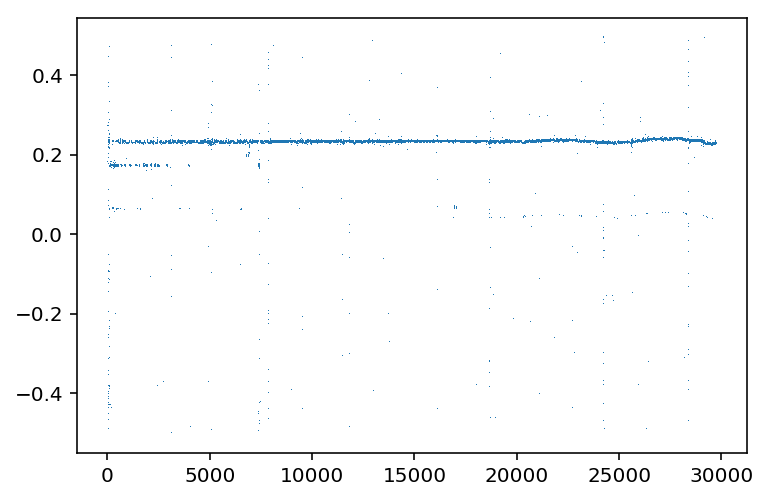

In [103]:
plt.plot(res, ",")

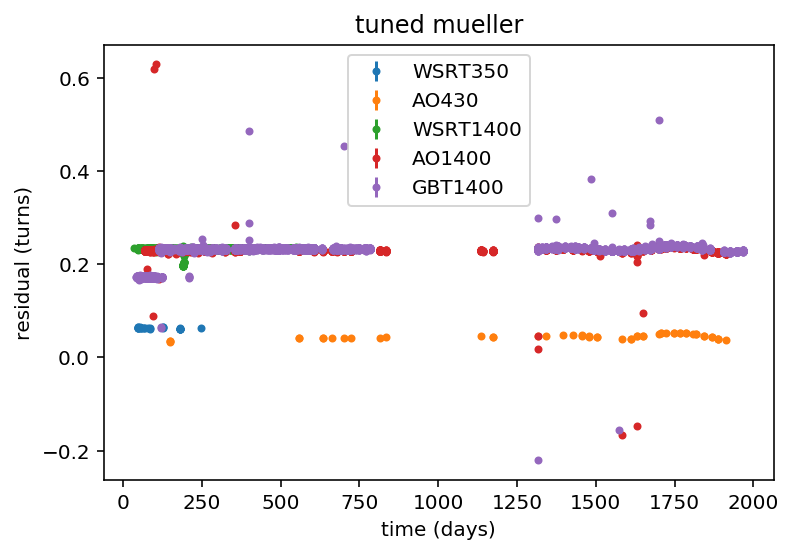

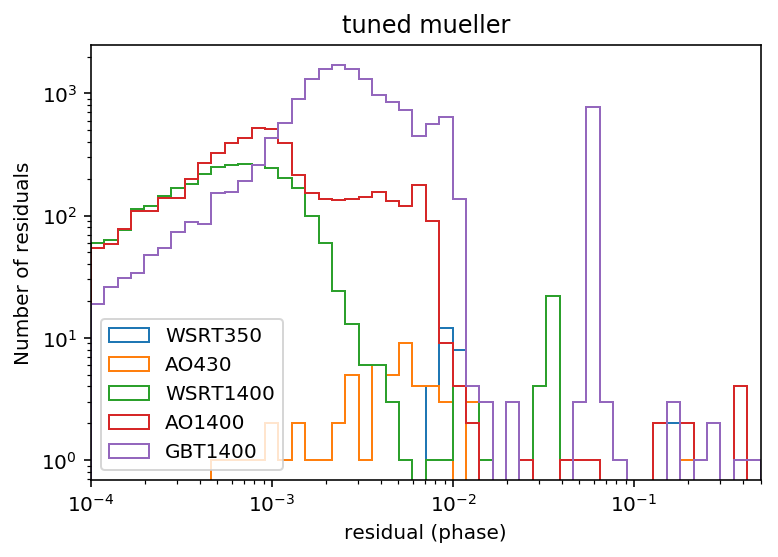

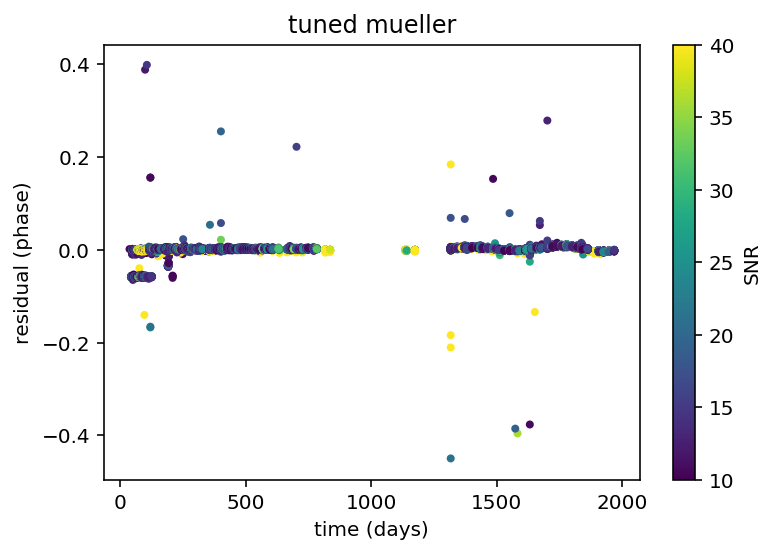

In [104]:
# FIXME: compensates for wrong SNR calculation
plt.figure(1)
plt.figure(2)
plt.figure(3)

cm = plt.get_cmap("viridis")
cNorm  = matplotlib.colors.Normalize(vmin=10, vmax=40)
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cm)

def key(t):
    return t["flags"]["tel"], int(t["flags"]["band"])
def wrap(a,center=0):
    return (a+0.5-center) % 1 - 0.5 + center
def fmtk(k):
    return "%s%s" % k
subsets = {}
snrs = np.zeros(len(toa_info))

be = 10**np.linspace(np.log10(1e-4),np.log10(0.5),50+1)

for i,t in enumerate(toa_info):
    k = key(t)
    if k not in subsets:
        subsets[k] = np.zeros(len(toa_info),dtype=bool)
    snr = float(t["flags"]["snr"])
    snrs[i] = snr
    if snr>10:
        subsets[k][i] = True

for k,c in subsets.items():
    m = scipy.stats.circmean(res[c], high=1)
    r = wrap(res[c],m)
    plt.figure(1)
    plt.errorbar(F.mjds[c], r, F.uncerts[c], linestyle="none", marker=".", label=fmtk(k))
    plt.figure(2)
    plt.hist(np.abs(r-m),histtype="step",range=(0,0.5),bins=be, label=fmtk(k))
    plt.figure(3)
    #colors = [scalarMap.to_rgba(s) for s in snrs[c]]
    plt.scatter(F.mjds[c], r-m, marker=".", c=snrs[c], vmin=10, vmax=40)
    
plt.figure(1)
plt.legend(loc="best")
plt.xlabel("time (days)")
plt.ylabel("residual (turns)")
plt.title("%s %s" % (toa_info[0]["flags"]["processing_name"],toa_info[0]["flags"]["toa_name"]))
plt.savefig("outliers-raw.pdf")
plt.figure(2)
plt.xlim(be[0],be[-1])
plt.legend(loc="lower left")
plt.gca().set_yscale('log',nonposy='clip')
plt.gca().set_xscale('log')             
plt.xlabel("residual (phase)")
plt.ylabel("Number of residuals")
plt.title("%s %s" % (toa_info[0]["flags"]["processing_name"],toa_info[0]["flags"]["toa_name"]))
plt.savefig("outliers-dist.pdf")
plt.figure(3)
plt.title("%s %s" % (toa_info[0]["flags"]["processing_name"],toa_info[0]["flags"]["toa_name"]))
plt.xlabel("time (days)")
plt.ylabel("residual (phase)")
plt.colorbar(label="SNR")
plt.savefig("outliers-snr.pdf")



In [105]:
masks = {}
ix_inv = np.argsort(F.ix)
for (i,t) in enumerate(toa_info):
    k = key(t)
    if k not in masks:
        masks[k] = np.zeros(len(toa_info), dtype=bool)
    i_array = ix_inv[i] # FIXME: this or inverse?
    f = t["flags"]
    if float(f["snr"])<10:
        continue
    if "mode" in f and f["mode"]=="search":
        continue
    masks[k][i_array] = True


In [106]:
means = {}
for k, c in masks.items():
    m = scipy.stats.circmean(res[c], high=1)
    print k, m, np.sum(c)
    means[k] = m

('WSRT', 350) 0.062742914909 29
('AO', 430) 0.0447528988632 54
('WSRT', 1400) 0.232340274127 3406
('AO', 1400) 0.229371990334 5660
('GBT', 1400) 0.232971613842 15152


In [108]:
r = F.residuals(bp_clean)
for (i,t) in enumerate(toa_info):
    k = key(t)
    i_array = ix_inv[i] # FIXME: this or inverse?
    dp = np.round(r[i_array]-means[k])
    if dp!=0:
        print r[i_array]-means[k], t["mjd"]
    F.pulses[i_array] += dp
    t["flags"]["pn"] = str(F.pulses[i_array])

In [112]:
threebody.write_t2_toas("tuned_mueller_pulses.tim",toa_info)

In [120]:
clean_toa_info = []
for t in toa_info:
    k = key(t)
    f = t["flags"]
    if float(f["snr"])<10:
        continue
    if "mode" in f and f["mode"]=="search":
        continue
    clean_toa_info.append(t)
threebody.write_t2_toas("tuned_mueller_pulses_selected.tim",
                        clean_toa_info)
print len(clean_toa_info), len(toa_info)

24301 29744


## Check out cleaned-up tim file

In [126]:
fpickle = "forecaster_params.pickle"
d = pickle.load(open(fpickle,"rb"))
d["files"] = "tuned_mueller_pulses_selected"
d["toa_mode"] = "pipeline"
Fc = threebody.Fitter(**d)
d

{'efac': (('AO1440', 1.45), ('GBT1500', 1.11), ('WSRT1400', 1.45)),
 'files': 'tuned_mueller_pulses_selected',
 'fit_pm': False,
 'fit_pos': True,
 'fit_px': False,
 'kopeikin': False,
 'parfile': '0337_tempo2_px_optical.par',
 'ppn_mode': 'heavysimple',
 'priors': ('dbeta', 'dgamma'),
 't2_astrometry': True,
 'toa_mode': 'pipeline',
 'tzrmjd_middle': False}

24301


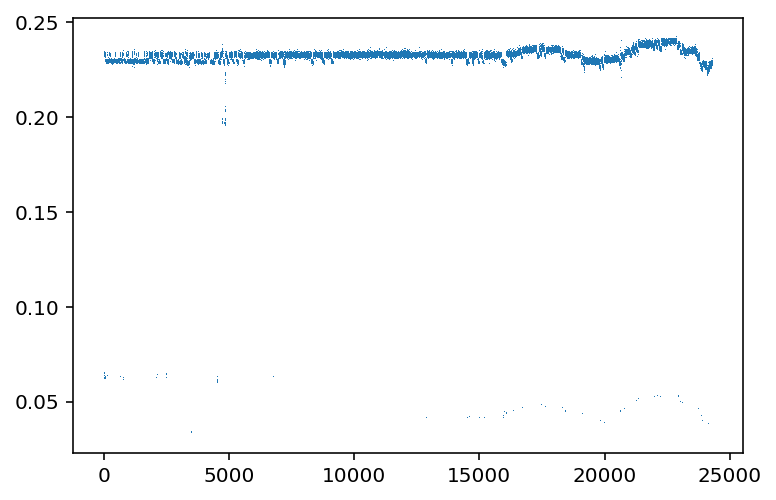

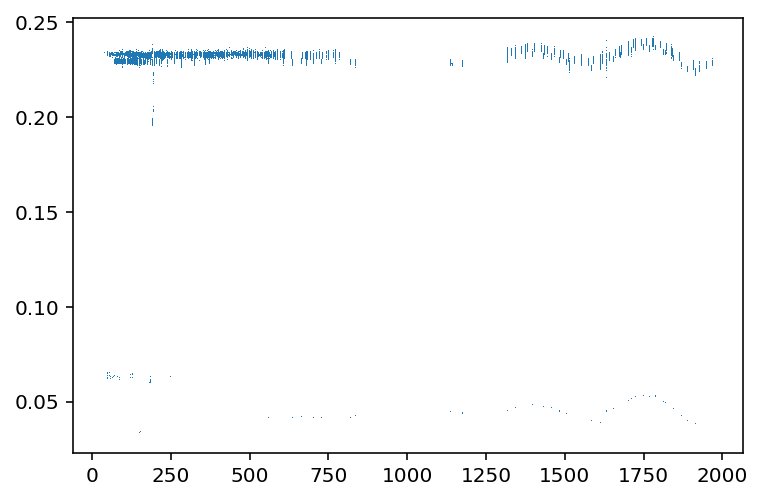

In [125]:
r = Fc.residuals(bp_clean)
res = r
plt.plot(res, ",")
plt.figure()
plt.plot(Fc.mjds, res, ",")
print len(res)